In [1]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
sc= SparkContext()
sqlContext = SQLContext(sc)

df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('insurance.csv')
df.take(1)

[Row(age=19, sex='female', bmi=27.9, children=0, smoker='yes', region='southwest', charges=16884.924)]

## Data Exploration

In [2]:
df.cache()

#print schema in tree format
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: integer (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- charges: double (nullable = true)



In [3]:
#descriptive analytics
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,1338,39.20702541106129,14.049960379216147,18,64
sex,1338,None,None,female,male
bmi,1338,30.663396860986538,6.098186911679012,15.96,53.13
children,1338,1.0949177877429,1.205492739781914,0,5
smoker,1338,None,None,no,yes
region,1338,None,None,northeast,southwest
charges,1338,13270.422265141257,12110.011236693992,1121.8739,63770.42801


In [4]:
#correlation figures between charges and other variables
import six
for i in df.columns:
    if not( isinstance(df.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to charges for ", i, df.stat.corr('charges',i))

Correlation to charges for  age 0.299008193330648
Correlation to charges for  bmi 0.19834096883362906
Correlation to charges for  children 0.06799822684790494
Correlation to charges for  charges 1.0


In [5]:
#data types
df.dtypes

[('age', 'int'),
 ('sex', 'string'),
 ('bmi', 'double'),
 ('children', 'int'),
 ('smoker', 'string'),
 ('region', 'string'),
 ('charges', 'double')]

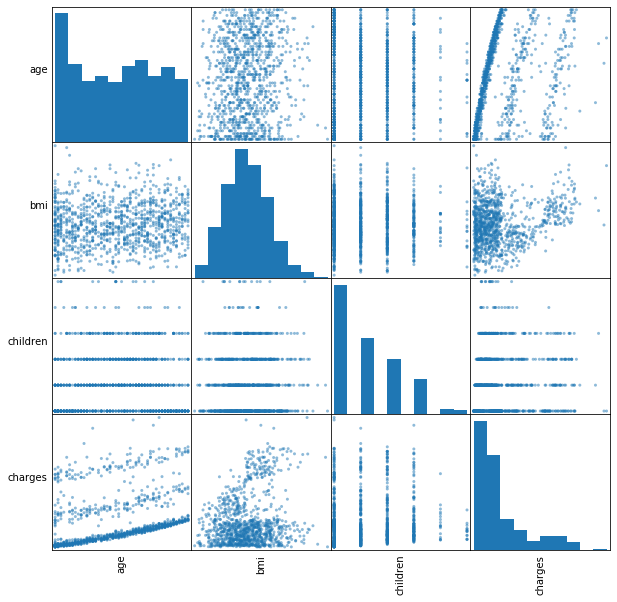

In [6]:
#scatter matrix to visualise correlations between independent variables
import pandas as pd
from pandas.plotting import scatter_matrix

numeric_features = [t[0] for t in df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = df.select(numeric_features).sample(False, 0.8).toPandas()
axs = scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

The above shows very little correlation between charges (target) and independent variables (all are fairly close to 0).

In [7]:
#function to find information about any missing values
def info_missing_table(df_pd):
    """Input pandas dataframe and Return columns with missing value and percentage"""
    mis_val = df_pd.isnull().sum() #count total of null in each columns in dataframe
    mis_val_percent = 100 * df_pd.isnull().sum() / len(df_pd) #count percentage of null in each columns
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)  #join to left (as column) between mis_val and mis_val_percent
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'}) #rename columns in table
    mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)         
    print ("Your selected dataframe has " + str(df_pd.shape[1]) + " columns.\n"  
    "There are " + str(mis_val_table_ren_columns.shape[0]) +              
    " columns that have missing values.") 
    return mis_val_table_ren_columns

In [8]:
df_pd = df.toPandas()
missings = info_missing_table(df_pd)
missings

Your selected dataframe has 7 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


No missing values found.

### Train / Test Split

In [9]:
#split data into training and testing sets
train, test = df.randomSplit([0.80, 0.20], seed = 42)
print(train.count())
print(test.count())

1071
267


### Process the data into vector format

Here, 2 columns are generated for use in machine learning - the target column charges, and the features column (a vector of all values of the predictor variables).

In [10]:
#OneHotEncoderEstimator from MLlib in spark to convert each v=categorical feature into one-hot vectors
#use VectorAssembler to combine resulting one-hot vector and rest of numerical features into a 
#single vector column, and append every step of the process in a stages array
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler

cat_cols = [item[0] for item in df.dtypes if item[1].startswith('string')] 

stages = []
for categoricalCol in cat_cols:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

del numeric_features[-1]
assemblerInputs = [c + "classVec" for c in cat_cols] + numeric_features
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [11]:
#use a pipeline to apply all stages of transformation to the data - train and test sets
from pyspark.ml import Pipeline
cols = df.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(train)
train = pipelineModel.transform(train)
test = pipelineModel.transform(test)

## Machine Learning

### Linear Regression

In [12]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol = 'features', labelCol='charges', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [53.76666454654814,-24097.257539210368,-1119.50301472429,-883.9395387071282,-0.0,247.99438318314276,338.8013200440111,342.6345378833097]
Intercept: 12531.951481045615


In [13]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 6161.291819
r2: 0.747323


In [14]:
train.describe().show()

+-------+------------------+------+------------------+------------------+------+---------+-----------------+------------------+-------------------+-----------------+
|summary|               age|   sex|               bmi|          children|smoker|   region|          charges|          sexIndex|        smokerIndex|      regionIndex|
+-------+------------------+------+------------------+------------------+------+---------+-----------------+------------------+-------------------+-----------------+
|  count|              1071|  1071|              1071|              1071|  1071|     1071|             1071|              1071|               1071|             1071|
|   mean| 38.90196078431372|  null|30.688076563958912|1.0812324929971988|  null|     null|13322.20923384594|0.4939309056956116|0.20634920634920634|1.438842203548086|
| stddev|14.149294288480005|  null| 6.067139261653774|1.2027743525253398|  null|     null|12262.84907506971|0.5001967378241552| 0.4048731489318663|1.123971664729318|
|   

In [15]:
lr_predictions = lr_model.transform(test)
lr_predictions.select("prediction","charges","features").show(5)

from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="charges",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+----------+--------------------+
|        prediction|   charges|            features|
+------------------+----------+--------------------+
|24334.286970495465|14283.4594|(8,[5,6],[18.0,21...|
|283.44816215106584| 2201.0971|[0.0,1.0,1.0,0.0,...|
|1395.7299458356156| 2196.4732|(8,[1,5,6],[1.0,1...|
|2400.5112077872764| 1622.1885|(8,[1,2,5,6],[1.0...|
| 3346.657299987781| 2801.2588|[0.0,1.0,1.0,0.0,...|
+------------------+----------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.763627


In [16]:
test_result = lr_model.evaluate(test)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 5578.82


In [17]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

numIterations: 11
objectiveHistory: [0.4999999999999998, 0.4140710928544661, 0.19704610986585364, 0.12730290445646422, 0.12688139117693248, 0.12657973931429883, 0.12643552876828326, 0.12636883173902785, 0.12636771982380227, 0.12636713147750972, 0.12636712539793538]
+-------------------+
|          residuals|
+-------------------+
|  2784.740831877482|
| 384.04027391002955|
|  780.5175908160561|
| -7923.299788068445|
| -257.0412341735905|
|  4544.001480784599|
| -898.1227422572119|
|  18243.25210774279|
|  -962.230893065575|
| -704.0922173775925|
| -329.3638740448059|
| -1507.150174936652|
|-1923.8531551910069|
|  8224.956302501376|
|-2757.2591156997137|
| -2634.084968029337|
| 7788.3074927602975|
|-2536.1804867320097|
|-3079.4679104874313|
| -3116.583155692273|
+-------------------+
only showing top 20 rows



In [18]:
predictions = lr_model.transform(test)
predictions.select("prediction","charges","features").show()

+------------------+-----------+--------------------+
|        prediction|    charges|            features|
+------------------+-----------+--------------------+
|24334.286970495465| 14283.4594|(8,[5,6],[18.0,21...|
|283.44816215106584|  2201.0971|[0.0,1.0,1.0,0.0,...|
|1395.7299458356156|  2196.4732|(8,[1,5,6],[1.0,1...|
|2400.5112077872764|  1622.1885|(8,[1,2,5,6],[1.0...|
| 3346.657299987781|  2801.2588|[0.0,1.0,1.0,0.0,...|
| 226.4238450232824|  1702.4553|(8,[0,1,5,6],[1.0...|
| 2126.085796529991|  1719.4363|[1.0,1.0,1.0,0.0,...|
|2349.6946677590386|  1720.3537|[1.0,1.0,1.0,0.0,...|
|  4279.82324666623|   3481.868|[1.0,1.0,0.0,0.0,...|
|  3616.81160472364|  1725.5523|[1.0,1.0,1.0,0.0,...|
| 4466.757713395247|  1141.4451|[1.0,1.0,1.0,0.0,...|
| 1825.428239881161| 2709.24395|[0.0,1.0,0.0,0.0,...|
| 26835.31013197128| 17468.9839|(8,[4,5,6],[1.0,1...|
| 3665.538126283098|   4687.797|[0.0,1.0,0.0,1.0,...|
| 5827.920631562294|  2138.0707|(8,[1,4,5,6],[1.0...|
|27146.565799751275| 17352.6

### Decision Tree Regressor

In [19]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'charges')
dt_model = dt.fit(train)
dt_predictions = dt_model.transform(test)
dt_evaluator = RegressionEvaluator(
    labelCol="charges", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 4457.44


In [20]:
dt_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="charges",metricName="r2")
print("R Squared (R2) on test data = %g" % dt_evaluator.evaluate(dt_predictions))

R Squared (R2) on test data = 0.849102


In [22]:
train.take(1)

[Row(age=18, sex='female', bmi=20.79, children=0, smoker='no', region='southeast', charges=1607.5101, sexIndex=1.0, sexclassVec=SparseVector(1, {}), smokerIndex=0.0, smokerclassVec=SparseVector(1, {0: 1.0}), regionIndex=0.0, regionclassVec=SparseVector(3, {0: 1.0}), features=SparseVector(8, {1: 1.0, 2: 1.0, 5: 18.0, 6: 20.79}))]

In [23]:
dt_model.featureImportances

SparseVector(8, {1: 0.7103, 2: 0.0009, 4: 0.0021, 5: 0.1128, 6: 0.1692, 7: 0.0048})

In [24]:
df.take(1)

[Row(age=19, sex='female', bmi=27.9, children=0, smoker='yes', region='southwest', charges=16884.924)]

Age is apparently the most important feature to predict cost of insurance.

### Gradient Boosted Tree Regressor

In [25]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'charges', maxIter=10)
gbt_model = gbt.fit(train)
gbt_predictions = gbt_model.transform(test)
gbt_predictions.select('prediction', 'charges', 'features').show(5)

+------------------+----------+--------------------+
|        prediction|   charges|            features|
+------------------+----------+--------------------+
|14951.395958939662|14283.4594|(8,[5,6],[18.0,21...|
|3623.5788120743427| 2201.0971|[0.0,1.0,1.0,0.0,...|
| 2144.740045137887| 2196.4732|(8,[1,5,6],[1.0,1...|
|3661.8854495136347| 1622.1885|(8,[1,2,5,6],[1.0...|
| 5600.179695675772| 2801.2588|[0.0,1.0,1.0,0.0,...|
+------------------+----------+--------------------+
only showing top 5 rows



In [26]:
gbt_evaluator = RegressionEvaluator(
    labelCol="charges", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 4507.88


In [27]:
gbt_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="charges",metricName="r2")
print("R Squared (R2) on test data = %g" % gbt_evaluator.evaluate(gbt_predictions))

R Squared (R2) on test data = 0.845668


### Random Forest Regressor

In [29]:
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(featuresCol = 'features', labelCol = 'charges')
rf_model = rf.fit(train)
rf_predictions = rf_model.transform(test)
rf_predictions.select('prediction', 'charges', 'features').show(5)

+------------------+----------+--------------------+
|        prediction|   charges|            features|
+------------------+----------+--------------------+
|18980.183398632802|14283.4594|(8,[5,6],[18.0,21...|
| 5590.661903293896| 2201.0971|[0.0,1.0,1.0,0.0,...|
| 5067.887190330231| 2196.4732|(8,[1,5,6],[1.0,1...|
| 5238.559494260627| 1622.1885|(8,[1,2,5,6],[1.0...|
| 6785.952500949659| 2801.2588|[0.0,1.0,1.0,0.0,...|
+------------------+----------+--------------------+
only showing top 5 rows



In [30]:
rf_evaluator = RegressionEvaluator(
    labelCol="charges", predictionCol="prediction", metricName="rmse")
rmse = rf_evaluator.evaluate(rf_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 4692.87


In [31]:
rf_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="charges",metricName="r2")
print("R Squared (R2) on test data = %g" % rf_evaluator.evaluate(rf_predictions))

R Squared (R2) on test data = 0.832741
